# Step 2: Building a GTFS graph and merging it with a walking graph
We heavily follow Kuan Butts's Calculating Betweenness Centrality with GTFS blog post: https://gist.github.com/kuanb/c54d0ae7ee353cac3d56371d3491cf56

The peartree (https://github.com/kuanb/peartree) source code was modified. Until code is merged you should use code from this fork: https://github.com/d3netxer/peartree

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import osmnx as ox
import pandas as pd
import geopandas as gpd
import networkx as nx
import numpy as np
from shapely.geometry import Point

In [4]:
import partridge as ptg

In [5]:
import os, sys

In [6]:
sys.path.append(r"C:\repos\peartree")
import peartree as pt

In [7]:
print(pt.__file__)

C:\repos\peartree\peartree\__init__.py


In [8]:
path = r'input_folder/cap_haitien_gtfs.zip'

### Build a graph from service_0001
service_0001 is on the weekends, so below we are choosing a data that lands on a weekend

In [9]:
# from: http://simplistic.me/playing-with-gtfs.html
import datetime

service_ids_by_date = ptg.read_service_ids_by_date(path)
service_ids = service_ids_by_date[datetime.date(2019, 6, 29)]

print(f"service_ids is {service_ids}")

# view lets you filter before you load the feed. For example, below you are filtering by the service_ids
feed = ptg.load_feed(path, view={
    'trips.txt': {
        'service_id': service_ids,
    },
})

service_ids is frozenset({'service_0001'})


In [10]:
feed.calendar

,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
0,service_0001,0,0,0,0,0,1,1,2019-06-29,2020-07-29


In [11]:
#feed.frequencies 

In [12]:
len(feed.trips)

26

In [13]:
# give all trips a direction of 0
feed.trips['direction_id'] = 0
feed.trips

,trip_id,route_id,service_id,trip_headsign,trip_short_name,direction_id,block_id,shape_id,wheelchair_accessible
0,trip_0004,route_0021,service_0001,Rue 0L,NaN,0,NaN,shape_0001,NaN
1,trip_0006,route_0002,service_0001,Grison Garde,NaN,0,NaN,shape_0002,NaN
2,trip_0010,route_0003,service_0001,Milot,NaN,0,NaN,shape_0003,NaN
3,trip_0014,route_0004,service_0001,Station Trou Du Nord,NaN,0,NaN,shape_0004,NaN
4,trip_0018,route_0003,service_0001,Pont Neuf 1,NaN,0,NaN,shape_0005,NaN
5,trip_0022,route_0006,service_0001,Madeline,NaN,0,NaN,shape_0006,NaN
6,trip_0024,route_0002,service_0001,Barrière Bouteille,NaN,0,NaN,shape_0007,NaN
7,trip_0028,route_0008,service_0001,Champin,NaN,0,NaN,shape_0008,NaN
8,trip_0030,route_0015,service_0001,Rue 0L,NaN,0,NaN,shape_0009,NaN
9,trip_0032,route_0010,service_0001,Ouanaminthe,NaN,0,NaN,shape_0010,NaN


## Preview the GTFS network

In [14]:
# Set a target time period to summarize impedance
start = 0  # 0:00 
end = 24*60*60  # 24:00 

# Converts feed subset into a directed
# network multigraph
G = pt.load_feed_as_graph(feed, start, end, add_trips_per_edge=True)

C:\Users\war-machine\Anaconda2\envs\gostnets2\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


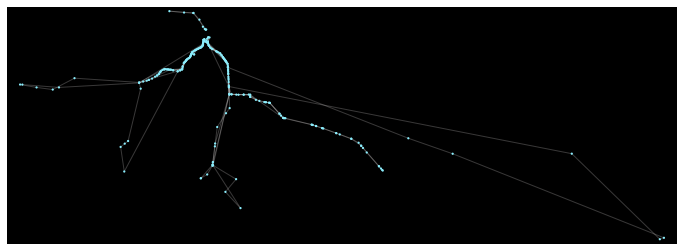

In [15]:
fig, ax = ox.plot_graph(G,
                            figsize=(12,12),
                            show=False,
                            close=False,
                            node_color='#8aedfc',
                            node_size=5,
                            edge_color='#e2dede',
                            edge_alpha=0.25,
                            bgcolor='black')

In [16]:
list(G.edges)

[('9C2ZJ_stop_0119', '9C2ZJ_stop_0096', 0),
 ('9C2ZJ_stop_0143', '9C2ZJ_stop_0260', 0),
 ('9C2ZJ_stop_0143', '9C2ZJ_stop_0081', 0),
 ('9C2ZJ_stop_0143', '9C2ZJ_stop_0154', 0),
 ('9C2ZJ_stop_0176', '9C2ZJ_stop_0074', 0),
 ('9C2ZJ_stop_0217', '9C2ZJ_stop_0001', 0),
 ('9C2ZJ_stop_0217', '9C2ZJ_stop_0034', 0),
 ('9C2ZJ_stop_0232', '9C2ZJ_stop_0104', 0),
 ('9C2ZJ_stop_0250', '9C2ZJ_stop_0228', 0),
 ('9C2ZJ_stop_0129', '9C2ZJ_stop_0173', 0),
 ('9C2ZJ_stop_0129', '9C2ZJ_stop_0001', 0),
 ('9C2ZJ_stop_0128', '9C2ZJ_stop_0230', 0),
 ('9C2ZJ_stop_0128', '9C2ZJ_stop_0090', 0),
 ('9C2ZJ_stop_0003', '9C2ZJ_stop_0152', 0),
 ('9C2ZJ_stop_0003', '9C2ZJ_stop_0023', 0),
 ('9C2ZJ_stop_0095', '9C2ZJ_stop_0248', 0),
 ('9C2ZJ_stop_0095', '9C2ZJ_stop_0211', 0),
 ('9C2ZJ_stop_0182', '9C2ZJ_stop_0258', 0),
 ('9C2ZJ_stop_0182', '9C2ZJ_stop_0072', 0),
 ('9C2ZJ_stop_0087', '9C2ZJ_stop_0054', 0),
 ('9C2ZJ_stop_0087', '9C2ZJ_stop_0063', 0),
 ('9C2ZJ_stop_0087', '9C2ZJ_stop_0140', 0),
 ('9C2ZJ_stop_0117', '9C2ZJ_stop

In [17]:
list(G.edges(data='True'))

[('9C2ZJ_stop_0119', '9C2ZJ_stop_0096', None),
 ('9C2ZJ_stop_0143', '9C2ZJ_stop_0260', None),
 ('9C2ZJ_stop_0143', '9C2ZJ_stop_0081', None),
 ('9C2ZJ_stop_0143', '9C2ZJ_stop_0154', None),
 ('9C2ZJ_stop_0176', '9C2ZJ_stop_0074', None),
 ('9C2ZJ_stop_0217', '9C2ZJ_stop_0001', None),
 ('9C2ZJ_stop_0217', '9C2ZJ_stop_0034', None),
 ('9C2ZJ_stop_0232', '9C2ZJ_stop_0104', None),
 ('9C2ZJ_stop_0250', '9C2ZJ_stop_0228', None),
 ('9C2ZJ_stop_0129', '9C2ZJ_stop_0173', None),
 ('9C2ZJ_stop_0129', '9C2ZJ_stop_0001', None),
 ('9C2ZJ_stop_0128', '9C2ZJ_stop_0230', None),
 ('9C2ZJ_stop_0128', '9C2ZJ_stop_0090', None),
 ('9C2ZJ_stop_0003', '9C2ZJ_stop_0152', None),
 ('9C2ZJ_stop_0003', '9C2ZJ_stop_0023', None),
 ('9C2ZJ_stop_0095', '9C2ZJ_stop_0248', None),
 ('9C2ZJ_stop_0095', '9C2ZJ_stop_0211', None),
 ('9C2ZJ_stop_0182', '9C2ZJ_stop_0258', None),
 ('9C2ZJ_stop_0182', '9C2ZJ_stop_0072', None),
 ('9C2ZJ_stop_0087', '9C2ZJ_stop_0054', None),
 ('9C2ZJ_stop_0087', '9C2ZJ_stop_0063', None),
 ('9C2ZJ_stop

In [18]:
len(G.nodes)

261

In [19]:
for edge in list(G.edges):
    print(G.get_edge_data(edge[0],edge[1]))

{0: {'length': 2119.0, 'trips': 1, 'mode': 'transit'}}
{0: {'length': 1462.0, 'trips': 1, 'mode': 'transit'}}
{0: {'length': 74.0, 'trips': 2, 'mode': 'transit'}}
{0: {'length': 122.0, 'trips': 1, 'mode': 'transit'}}
{0: {'length': 706.0, 'trips': 1, 'mode': 'transit'}}
{0: {'length': 1213.0, 'trips': 1, 'mode': 'transit'}}
{0: {'length': 648.0, 'trips': 1, 'mode': 'transit'}}
{0: {'length': 1257.0, 'trips': 1, 'mode': 'transit'}}
{0: {'length': 2657.0, 'trips': 1, 'mode': 'transit'}}
{0: {'length': 14.0, 'trips': 1, 'mode': 'transit'}}
{0: {'length': 30.0, 'trips': 1, 'mode': 'transit'}}
{0: {'length': 138.0, 'trips': 1, 'mode': 'transit'}}
{0: {'length': 86.0, 'trips': 1, 'mode': 'transit'}}
{0: {'length': 98.0, 'trips': 1, 'mode': 'transit'}}
{0: {'length': 45.0, 'trips': 1, 'mode': 'transit'}}
{0: {'length': 285.0, 'trips': 1, 'mode': 'transit'}}
{0: {'length': 104.0, 'trips': 2, 'mode': 'transit'}}
{0: {'length': 198.0, 'trips': 1, 'mode': 'transit'}}
{0: {'length': 79.0, 'trips':

## Inspect graph as a shapefile
Used for testing

In [192]:
# Get reference to GOSTNets
#import sys
#sys.path.append(r'C:\Users\war-machine\Documents\world_bank_work\cityscan\GOSTnets')
#import GOSTnets as gn

In [193]:
#gn.save(G,"gtfs_export_cap_haitien",r"C:\Users\war-machine\Documents\world_bank_work\haiti_gtfs_project\output_gtfs_graph_24hr_frame")

note: On inspection the edges have a length field. This length field is the average traversal time per edge based on the GTFS data in seconds.

## Merge a walk network
following this blog post: http://kuanbutts.com/2018/12/24/peartree-with-walk-network/

In [194]:
# load existing walk/ferry graph from step 1
G = nx.read_gpickle(r"temp\cap_haitien_walk_w_ferries_via_osmnx.pickle")

In [195]:
print(nx.info(G))

Name: 
Type: MultiDiGraph
Number of nodes: 12931
Number of edges: 34334
Average in degree:   2.6552
Average out degree:   2.6552


### Assign traversal times in seconds to edges
Since peartree represents edge length (that is the impedance value associated with the edge) in seconds; we will need to convert the edge values that are in meters into seconds:

In [196]:
walk_speed = 3.5  # about 3 miles per hour
ferry_speed = 15

# Make a copy of the graph in case we make a mistake
G_adj = G.copy()

# Iterate through and convert lengths to seconds
for from_node, to_node, edge in G_adj.edges(data=True):
    orig_len = edge['length']
    
    # Note that this is a MultiDiGraph so there could
    # be multiple indices here, I naively assume this is not the case
    G_adj[from_node][to_node][0]['orig_length'] = orig_len

    # if ferry
    try:
        print(G_adj[from_node][to_node][0]['ferry'])
        print(G_adj[from_node][to_node][0])
        
        # Conversion of walk speed and into seconds from meters
        kmph = (orig_len / 1000) / ferry_speed
        in_seconds = kmph * 60 * 60
        G_adj[from_node][to_node][0]['length'] = in_seconds
    
        # And state the mode, too
        G_adj[from_node][to_node][0]['mode'] = 'ferry'
    except:
        # Conversion of walk speed and into seconds from meters
        kmph = (orig_len / 1000) / walk_speed
        in_seconds = kmph * 60 * 60
        G_adj[from_node][to_node][0]['length'] = in_seconds
    
        # And state the mode, too
        G_adj[from_node][to_node][0]['mode'] = 'walk'

unclassified
{'osmid': 212397499, 'ferry': 'unclassified', 'oneway': False, 'length': 8474.458, 'geometry': <shapely.geometry.linestring.LineString object at 0x000001C01892B048>, 'orig_length': 8474.458}
unclassified
{'osmid': 214459218, 'ferry': 'unclassified', 'oneway': False, 'length': 1449.198, 'geometry': <shapely.geometry.linestring.LineString object at 0x000001C01892B108>, 'orig_length': 1449.198}
unclassified
{'osmid': 233037712, 'ferry': 'unclassified', 'oneway': False, 'length': 1186.217, 'geometry': <shapely.geometry.linestring.LineString object at 0x000001C01892B188>, 'orig_length': 1186.217}
unclassified
{'osmid': 233037714, 'ferry': 'unclassified', 'oneway': False, 'length': 888.716, 'geometry': <shapely.geometry.linestring.LineString object at 0x000001C01892B208>, 'orig_length': 888.716}
unclassified
{'osmid': 337815403, 'ferry': 'unclassified', 'oneway': False, 'length': 1428.7089999999998, 'geometry': <shapely.geometry.linestring.LineString object at 0x000001C01892B288

In [197]:
G_adj.nodes[330530920]

{'y': 19.6193274, 'x': -72.0230707, 'osmid': 330530920}

In [198]:
# So this should be easy - just go through all nodes
# and make them have a 0 cost to board
for i, node in G_adj.nodes(data=True):
    G_adj.nodes[i]['boarding_cost'] = 0

In [199]:
list(G_adj.edges(data=True))[:2]

[(247844908,
  3806054858,
  {'osmid': [379649269, 233072790],
   'highway': 'footway',
   'oneway': False,
   'length': 1262.7689142857146,
   'geometry': <shapely.geometry.linestring.LineString at 0x1c01f0def48>,
   'orig_length': 1227.6920000000002,
   'mode': 'walk'}),
 (330521785,
  2353905402,
  {'osmid': [227769624, 226616997],
   'highway': ['unclassified', 'footway'],
   'oneway': False,
   'length': 1360.701257142857,
   'geometry': <shapely.geometry.linestring.LineString at 0x1c01f0de948>,
   'orig_length': 1322.904,
   'mode': 'walk'})]

In [200]:
# save the graph again to be used for the isochrones notebook

In [201]:
gn.save(G,"cap_haitien_walk_w_ferries_via_osmnx_w_time",r"temp")

## Loading the feed as a graph with the walking graph as the existing graph
Now that the two graphs have the same internal structures, we can load the walk network onto the transit network with the following peartree helper method.

In [202]:
# Now that we have a formatted walk network
# it should be easy to reload the peartree graph
# and stack it on the walk network
start = 0  # 0:00 
end = 24*60*60  # 24:00 

# Note this will be a little slow - an optimization here would be
# to have coalesced the walk network
%time G2 = pt.load_feed_as_graph(feed, start, end, existing_graph=G_adj,impute_walk_transfers=True)

Wall time: 2.57 s


In [203]:
G2

In [204]:
list(G2.edges(data=True))[0]

(247844908,
 3806054858,
 {'osmid': [379649269, 233072790],
  'highway': 'footway',
  'oneway': False,
  'length': 1262.7689142857146,
  'geometry': <shapely.geometry.linestring.LineString at 0x1c01f0def48>,
  'orig_length': 1227.6920000000002,
  'mode': 'walk'})

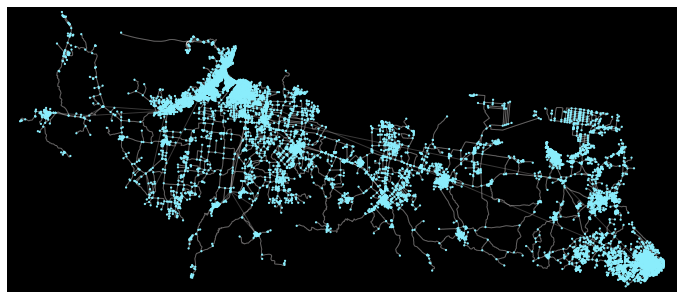

In [205]:
fig, ax = ox.plot_graph(G2,
                            figsize=(12,12),
                            show=False,
                            close=False,
                            node_color='#8aedfc',
                            node_size=5,
                            edge_color='#e2dede',
                            edge_alpha=0.25,
                            bgcolor='black')

## Identify only the largest graph

In [206]:
# compatible with NetworkX 2.4
list_of_subgraphs = list(G2.subgraph(c).copy() for c in nx.weakly_connected_components(G2))
max_graph = None
max_edges = 0
for i in list_of_subgraphs:
    if i.number_of_edges() > max_edges:
        max_edges = i.number_of_edges()
        max_graph = i

# set your graph equal to the largest sub-graph
G_service0001 = max_graph

In [207]:
# save again and inspect
gn.save(G_service0001,"gtfs_export_cap_haitien_merged_impute_walk_v4_service0001",r"temp")

now go on to network analysis with GOSTNets...